In [2]:
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F


In [3]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])
# celebrity_data = datasets.CelebA(root='./data', download=True, transform=transform)
# Load the training set
celebrity_train = datasets.CelebA(root='./data', split='train', download=True, transform=transform)

# Load the test set
celebrity_test = datasets.CelebA(root='./data', split='test', download=True, transform=transform)

In [4]:

class Generator(nn.Module):
    def __init__(self, z_dim, img_channels, feature_maps=64):
        super().__init__()
        self.gen = nn.Sequential(
            # nn.Linear(z_dim, z_dim),
            nn.ConvTranspose2d(z_dim, feature_maps*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps*8),
            nn.ReLU(True),
            nn.LazyConvTranspose2d(feature_maps*8, 4,1,0,bias=False),
            nn.BatchNorm2d(feature_maps*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps*8, feature_maps*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps*4, feature_maps*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps*2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.gen(x)


class Discriminator(nn.Module):
    def __init__(self, img_channels, feature_maps=64):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps*2, feature_maps*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps*4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        # return self.disc(x).view(-1)
        return self.disc(x).view(x.size(0), -1).mean(dim=1)

In [5]:

# Hyperparameters
z_dim = 32
img_size = 64
img_channels = 3
batch_size = 64
lr = 2e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])
# dataset = datasets.ImageFolder(root='./data', transform=transform)
dataset = datasets.CelebA(root='./data', split='train', transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Models
generator = Generator(z_dim, img_channels).to(device)
discriminator = Discriminator(img_channels).to(device)

# Optimizers
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

for epoch in range(50):
    for real, _ in loader:
        real = real.to(device)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, z_dim, 1, 1, device=device)

        # Train Discriminator
        fake = generator(noise).detach()
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        disc_real = discriminator(real)
        disc_fake = discriminator(fake)

        loss_disc = (criterion(disc_real, real_labels) + criterion(disc_fake, fake_labels)) / 2
        discriminator.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator
        fake = generator(noise)
        gen_labels = torch.ones(batch_size, device=device)
        out = discriminator(fake)

        loss_gen = criterion(out, gen_labels)
        generator.zero_grad()
        loss_gen.backward()
        opt_gen.step()

    print(f"Epoch [{epoch+1}/50] Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}")
# torch.save(generator.state_dict(), './models/generator.pth')
# torch.save(discriminator.state_dict(), './models/discriminator.pth')

Epoch [1/50] Loss D: 0.0010, Loss G: 6.7592
Epoch [2/50] Loss D: 0.0045, Loss G: 5.2600
Epoch [3/50] Loss D: 0.0003, Loss G: 8.1012
Epoch [4/50] Loss D: 0.0001, Loss G: 9.2974
Epoch [5/50] Loss D: 0.0007, Loss G: 7.3289
Epoch [6/50] Loss D: 0.0003, Loss G: 7.7144
Epoch [7/50] Loss D: 0.0008, Loss G: 7.4481
Epoch [8/50] Loss D: 0.0000, Loss G: 10.9002
Epoch [9/50] Loss D: 0.0000, Loss G: 12.0104
Epoch [10/50] Loss D: 0.0000, Loss G: 14.8097
Epoch [11/50] Loss D: 0.0000, Loss G: 16.3333
Epoch [12/50] Loss D: 0.0000, Loss G: 9.5073
Epoch [13/50] Loss D: 0.0004, Loss G: 8.3100
Epoch [14/50] Loss D: 0.0000, Loss G: 10.4797
Epoch [15/50] Loss D: 0.0000, Loss G: 11.9976
Epoch [16/50] Loss D: 0.0000, Loss G: 10.2463
Epoch [17/50] Loss D: 0.0000, Loss G: 10.4482
Epoch [18/50] Loss D: 0.0000, Loss G: 13.3852
Epoch [19/50] Loss D: 0.0001, Loss G: 9.7260
Epoch [20/50] Loss D: 0.0000, Loss G: 13.0784
Epoch [21/50] Loss D: 0.0000, Loss G: 14.5270
Epoch [22/50] Loss D: 0.0000, Loss G: 15.8511
Epoch [

generated fake images: torch.Size([64, 3, 112, 112])


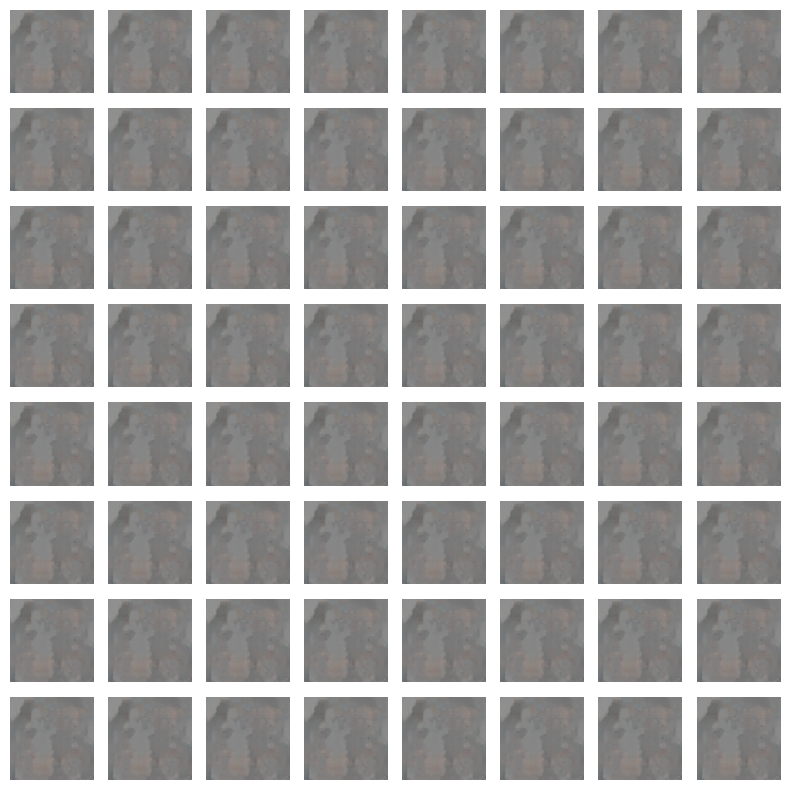

In [6]:
# %matplotlib inline

# generator = Generator(z_dim, img_channels=3).to(device)
# discriminator = Discriminator(z_dim).to(device)

# generator.load_state_dict(torch.load('./models/generator.pth'))
# discriminator.load_state_dict(torch.load('./models/discriminator.pth'))

# Set to eval mode
generator.eval()

# Sample fixed noise vector
z = torch.randn(64, z_dim, 1, 1).to(device)

# Generate fake images
with torch.no_grad():
    fake_images = generator(z)
    print(f'generated fake images: {fake_images.shape}')

# Un-normalize (-1 to 1 → 0 to 1) if you used Tanh in generator
fake_images = (fake_images + 1) / 2



grid = fake_images.cpu().numpy().transpose(0, 2, 3, 1)  # NCHW → NHWC

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(grid[i])
    ax.axis('off')
plt.tight_layout()
plt.show()